# Finding OZ and Pz electrodes

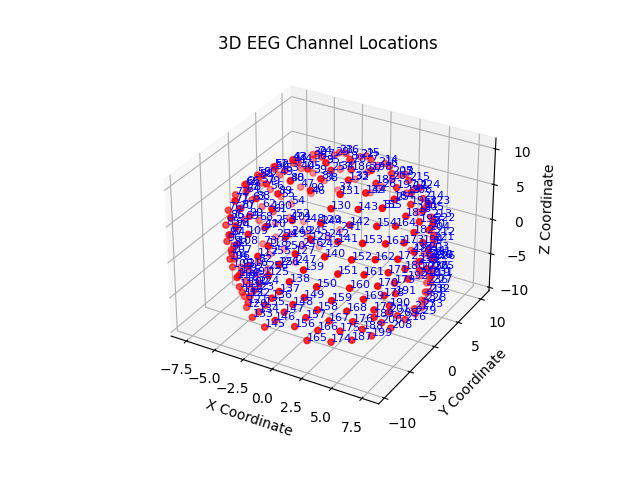

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget


# first set Cz as 257 in the file
file_path = "/home/arashsm79/playground/eeg-analysis/data/23306054/Tononi Serial Awakenings-Part1-No_PSGs/Tononi Serial Awakenings/Data/HydroCelGSN256v10.sfp"

def load_sfp_file(file_path):
    # Reading data assuming the file contains the format:
    # index   x      y      z
    data = np.loadtxt(file_path)
    return data[:, 0].astype(int), data[:, 1], data[:, 2], data[:, 3]  # return index, x, y, z

def plot_eeg_channels(x, y, z, indices):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='r', marker='o')

    for i, index in enumerate(indices):
        ax.text(x[i], y[i], z[i], str(index), color='blue', fontsize=8)

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.set_title('3D EEG Channel Locations')
    plt.show()

indices, x, y, z = load_sfp_file(file_path)

plot_eeg_channels(x, y, z, indices)

# OZ: 8, 15, 21 right down 257 is front

# PZ: 147, 137, 126

# pz: 137
# oz: 15

In [8]:
import logging
import sys
import os
import pandas as pd
import numpy as np
import dill
from scipy.stats import pearsonr
from sklearn.feature_selection import mutual_info_regression
import mne
import mne_connectivity
sys.modules["mne.connectivity"] = mne_connectivity # NOTE: monkey patching this for now. pySPI should probably fix this.
from pathlib import Path
from mne.preprocessing import ICA
from pyspi.calculator import Calculator

# from jpype import JPackage, startJVM, getDefaultJVMPath
# startJVM(getDefaultJVMPath())


logging.basicConfig(level=logging.INFO)

def preprocess_signal(raw):
    raw.filter(l_freq=1, h_freq=50, verbose=False)
    ica = ICA(n_components=15, random_state=97, max_iter=800, verbose=False) # https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#fitting-ica
    ica.fit(raw)
    ica.apply(raw)
    return raw

data_root = Path("/home/arashsm79/playground/eeg-analysis/data/23306054")
records_path = data_root / "Tononi Serial Awakenings-Part1-No_PSGs/Tononi Serial Awakenings/Records.csv"
channel_names = ['Chan 15', 'Chan 137']

records = pd.read_csv(records_path)
calc_set = None

for _, row in records.iterrows():
    subject_dir = data_root / f"Tononi Serial Awakenings-Part{row['Subject ID']+1}-s{row['Subject ID']:02d}_PSGs"

    eeg_filepath = next(subject_dir.rglob(row['Filename']))
    logging.info(f"Subject ID: {row['Subject ID']}, Filename: {row['Filename']}")
    logging.info(f"Processing {eeg_filepath}")

    raw = mne.io.read_raw_edf(eeg_filepath, preload=True, verbose=False)

    preprocessed_data = preprocess_signal(raw)
    coi_data = preprocessed_data.get_data(picks=channel_names)

    # calc_set = Calculator(coi_data, subset="fast")
    # calc_set.compute()
    
    with open('/home/arashsm79/Downloads/pyspi_calc_set1.pkl', 'rb') as f:
        # uncomment line 17 to 23 in .venv/lib/python3.11/site-packages/pyspi/statistics/infotheory.py to start jvm
        global calc_set
        calc_set = dill.load(f)

    break

# output_path = data_root / 'measures.csv'
# records.to_csv(output_path, index=False)

INFO:root:Subject ID: 1, Filename: s01_ep01.edf
INFO:root:Processing /home/arashsm79/playground/eeg-analysis/data/23306054/Tononi Serial Awakenings-Part2-s01_PSGs/Tononi Serial Awakenings/Data/PSG/s01_ep01.edf


Fitting ICA to data using 257 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.9s.
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 257 PCA components


Detecting 1 CUDA device(s).
INFO:spectral_connectivity.connectivity:Using CPU for spectral_connectivity...
INFO:spectral_connectivity.transforms:Using CPU for spectral_connectivity...
Trying to unpickle estimator EmpiricalCovariance from version 0.24.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GraphicalLasso from version 0.24.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GraphicalLassoCV from version 0.24.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model

In [20]:
calc_set.table.columns.get_level_values(0).unique()

array([-0.2000796 , -0.32450279,  0.03737291,  0.08303202,  0.0093954 ,
       -0.29865894])

In [23]:
records = pd.read_csv(records_path)

records_with_spi = []
i = 0
for _, row in records.iterrows():
    subject_dir = data_root / f"Tononi Serial Awakenings-Part{row['Subject ID']+1}-s{row['Subject ID']:02d}_PSGs"

    eeg_filepath = next(subject_dir.rglob(row['Filename']))
    logging.info(f"Subject ID: {row['Subject ID']}, Filename: {row['Filename']}")
    logging.info(f"Processing {eeg_filepath}")
    calc_table = calc_set.table

    for feature_name in calc_table.columns.get_level_values(0).unique():
        spi = calc_table[feature_name].values[np.triu_indices_from(calc_table[feature_name], k=1)]
        row[feature_name] = spi.mean()
    records_with_spi.append(row)

    if i == 3:
        break
    i += 1


# output_path = data_root / 'measures.csv'
# records.to_csv(output_path, index=False)
spi_df = pd.DataFrame(records_with_spi)
spi_df

INFO:root:Subject ID: 1, Filename: s01_ep01.edf
INFO:root:Processing /home/arashsm79/playground/eeg-analysis/data/23306054/Tononi Serial Awakenings-Part2-s01_PSGs/Tononi Serial Awakenings/Data/PSG/s01_ep01.edf
INFO:root:Subject ID: 1, Filename: s01_ep02.edf
INFO:root:Processing /home/arashsm79/playground/eeg-analysis/data/23306054/Tononi Serial Awakenings-Part2-s01_PSGs/Tononi Serial Awakenings/Data/PSG/s01_ep02.edf
INFO:root:Subject ID: 1, Filename: s01_ep03.edf
INFO:root:Processing /home/arashsm79/playground/eeg-analysis/data/23306054/Tononi Serial Awakenings-Part2-s01_PSGs/Tononi Serial Awakenings/Data/PSG/s01_ep03.edf
INFO:root:Subject ID: 1, Filename: s01_ep04.edf
INFO:root:Processing /home/arashsm79/playground/eeg-analysis/data/23306054/Tononi Serial Awakenings-Part2-s01_PSGs/Tononi Serial Awakenings/Data/PSG/s01_ep04.edf


,Filename,Case ID,Subject ID,Experience,Treatment group,Duration,EEG sample rate,Number of EEG channels,Last sleep stage,Has EOG,...,coint_johansen_trace_stat_order-1_ardiff-1,coint_aeg_tstat_trend-c_autolag-aic_maxlag-10,coint_aeg_tstat_trend-ct_autolag-aic_maxlag-10,coint_aeg_tstat_trend-ct_autolag-bic_maxlag-10,pec,pec_orth,pec_log,pec_orth_log,pec_orth_abs,pec_orth_log_abs
0,s01_ep01.edf,1_1,1,2,NaN,120,500,257,2,0,...,85.702759,-7.081025,-7.081025,-7.307322,0.065278,0.016789,0.034815,0.011292,0.06658,0.08548
1,s01_ep02.edf,1_2,1,2,NaN,120,500,257,2,0,...,85.702759,-7.081025,-7.081025,-7.307322,0.065278,0.016789,0.034815,0.011292,0.06658,0.08548
2,s01_ep03.edf,1_3,1,2,NaN,120,500,257,2,0,...,85.702759,-7.081025,-7.081025,-7.307322,0.065278,0.016789,0.034815,0.011292,0.06658,0.08548
3,s01_ep04.edf,1_4,1,2,NaN,120,500,257,2,0,...,85.702759,-7.081025,-7.081025,-7.307322,0.065278,0.016789,0.034815,0.011292,0.06658,0.08548
